In [1]:
%pylab inline
from pygadgetreader import *
from halo import *
import biff
from astropy import constants
from astropy import units as u


Populating the interactive namespace from numpy and matplotlib


In [4]:
font = {'size':16, 'family':'serif'}
matplotlib.rc('font', **font)

In [ ]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
print(G_c)

NDM_MW = 1000000

## Objective: 
    
1. Found the most bounded particles of the LMC
2. What is the potential of that inner region in the outer regions

In [6]:
# Orbit of the N-body simulation
lmc_orbit = np.loadtxt('LMC_orbit/orbits/LMC6_H1.txt')

In [7]:
# Path to snaps
lmc_path = '../data/LMCMW/MWmLMC6/H1/'
lmc_snap = 'MWfLMC6H1'
N_snaps = 120

In [13]:
def mw_particles(xyz, vxyz, pot, ids, M, N_halo):
    id_cut = np.sort(ids)[N_halo]
    index_mw = np.where(ids<id_cut)[0]
    index_lmc = np.where(ids>=id_cut)[0]
    LMC_pos = xyz[index_lmc]
    LMC_vel = vxyz[index_lmc]
    LMC_pot = pot[index_lmc]
    LMC_ids = ids[index_lmc]
    LMC_mass = M[index_lmc]
    #index_cut = np.where(np.sqrt(LMC_pos[:,0]**2.0 + LMC_pos[:,1]**2.0 + LMC_pos[:,2]**2.0) <600)[0]
    return xyz[index_mw], vxyz[index_mw], M[index_mw], pot[index_mw], LMC_pos, LMC_vel, LMC_pot, LMC_ids, LMC_mass

In [11]:
def pot_contour(x, y, pot, n_bins):
    x_pot = np.linspace(min(x), max(x), n_bins)
    y_pot = np.linspace(min(y), max(y), n_bins)
    pot_grid = np.zeros((n_bins,  n_bins))

    for i in range(1,n_bins):
        for j in range(1,n_bins):
            index = np.where((x<x_pot[i]) & (x>x_pot[i-1]) & (y<y_pot[j]) & (y>y_pot[j-1]))[0]
            pot_grid[i][j] = np.mean(pot[index])
    return x_pot, y_pot, pot_grid

In [12]:
#Function that returns the radius at which the LMC is still spherical!
def sphere_radius(x,y,z):
    r = np.linspace(1, 300, 100)
    s=1
    q=1
    i=0
    while ((np.abs(s-1)< 0.1) & (np.abs(q-1)<0.1) & (i<200)):
        s, q = shapes.iterate_volume(x, y, z, r[i], 1E-1)
        i+=1
    return r[i-2]

In [9]:
# Function that concatenate MW and LMC characteristics

def MWLMC_all(MW_pos, LMC_pos, MW_M, LMC_M, MW_pot, LMC_pot):
    MWLMC = np.concatenate((MW_pos, LMC_pos), axis=0)
    MWLMC_M = np.concatenate((MW_M, LMC_M), axis=0)
    MWLMC_pot = np.concatenate((MW_pot, LMC_pot), axis=0)
    return MWLMC, MWLMC_M, MWLMC_pot

In [10]:
# Function that returns the LMC_inner particles, the mass of those particles and
# an array of masses of the lenght of the totoal LMC particles with M=0 for those
# particles outside the radius of the inner LMC particles
def mask(LMC_xyz, xcm, ycm, zcm, r_cut, M, pot):
    index_mask = np.where(np.sqrt((LMC_xyz[:,0]-xcm)**2.0 + (LMC_xyz[:,1]-ycm)**2.0 + (LMC_xyz[:,2]-zcm)**2.0)<r_cut)[0]
    index_out = np.where(np.sqrt((LMC_xyz[:,0]-xcm)**2.0 + (LMC_xyz[:,1]-ycm)**2.0 + (LMC_xyz[:,2]-zcm)**2.0)>=r_cut)[0]
    return LMC_xyz[index_out], LMC_xyz[index_mask], M[index_out], M[index_mask], pot[index_out], pot[index_mask]
    

In [16]:
def radius_lmc(snap_path, snap_base, N_i, N_f, sat_orbit, N_part_host):
    """
    Function that computes the radius at which a Satellite accretting into
    a host galaxy is spheric.
    It reads the snapshot containin all the DM particles of the Satellite
    and the halo.
    
    Parameters:
    -----------
    snap_path: string
               path to the nbody snaphots

    snap_base: string
               snapshot base name in doesn't have to include the _000.hdf5
    
    N_i: int
         Number of the initial snapshot
    
    N_f: int
         Number of the final snapshot

    sat_orbit: 3d array
               Array with the positions of the satellite orbit at the corresponding
               snapshots [N_i-N_f].
    
    N_part_host: int
               Number of DM particles in the host halo.
               
    """
    
    N = N_f - N_i + 1
    R_cut = np.zeros(N)
    #print R_cut
    # For every snapshot
    for i in range(N_i, N_f+1):
        # Reading snapshot
        pos = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'pos', 'dm')
        M = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'mass', 'dm')
        vel = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'vel', 'dm')
        pot = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'pot', 'dm')
        pids = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'pid', 'dm')
        # Distinguish between MW and LMC particles
        MW_pos, MW_vel, MW_mass, MW_pot, LMC_pos, LMC_vel, LMC_mass, LMC_pot = host_sat_particles(pos, vel, pids, \
                                                                                                  N_part_host, pot,\
                                                                                                  M)
        # Centering LMC particles at their CM
        LMC_cx = LMC_pos[:,0] - sat_orbit[i,2]
        LMC_cy = LMC_pos[:,1] - sat_orbit[i,3]
        LMC_cz = LMC_pos[:,2] - sat_orbit[i,4]
        #print sum(LMC_mass)
        #print 'finding the rcut'
        R_cut[i-N_i] = sphere_radius(LMC_cx, LMC_cy, LMC_cz)
    return R_cut

In [3]:
def mask_satellite(snap_path, snap_base, N_i, N_f, lmc_orbit, N_part_host):
    # For every snapshot
    for i in range(N_i, N_f+1):
        # Reading snapshot
        pos = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'pos', 'dm')
        M = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'mass', 'dm')
        vel = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'vel', 'dm')
        pot = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'pot', 'dm')
        pids = readsnap(snap_path + snap_base + '_{:03d}'.format(i), 'pid', 'dm')
        # Distinguish between MW and LMC particles
        MW_pos, MW_vel, MW_mass, MW_pot, LMC_pos, LMC_vel, LMC_mass, LMC_pot = host_sat_particles(pos, vel, pids, \
                                                                                                  N_part_host, pot,\
                                                                                                  M)       
        # Centering LMC particles at their CM
        LMC_cx = LMC_pos[:,0] - lmc_orbit[i,2]
        LMC_cy = LMC_pos[:,1] - lmc_orbit[i,3]
        LMC_cz = LMC_pos[:,2] - lmc_orbit[i,4]
        #print 'finding the rcut'
        r_cut = sphere_radius(LMC_cx, LMC_cy, LMC_cz)
        #print 'masking'
        LMC_out, LMC_inn, M_out, M_inn, Pot_out, Pot_inn = mask(LMC_pos, lmc_orbit[i,2], lmc_orbit[i,3], lmc_orbit[i,4], 
                                              r_cut, LMC_mass, LMC_pot)
        MW_out, MW_inn, M_mwout, M_mwinn, Pot_mw_out, Pot_mwinn = mask(MW_pos, lmc_orbit[i,2], lmc_orbit[i,3], 
                                                                       lmc_orbit[i,4], r_cut, MW_mass, MW_pot)
        pos_out, mass_out, pot_out = MWLMC_all(MW_pos, LMC_out, MW_mass, M_out, MW_pot, Pot_out)
    #print max(np.abs(LMC_pot)) * pot_factor
    return (pos_out, mass_out, pot_out, LMC_inn, M_inn, Pot_inn)


In [14]:
#All_pos_out, All_mass_out, All_pot_out, LMC_inn_pos, LMC_mass_inn, LMC_pot_inn, MW_pos, MW_mass, MW_pot, LMC_pos_out, LMC_mass_out, LMC_pot_out = main(lmc_path, lmc_snap, 0, 0, lmc_orbit)
#All_pos_outf, All_mass_outf, All_pot_outf, LMC_inn_posf, LMC_mass_innf, LMC_pot_innf, MW_posf, MW_massf, MW_potf, LMC_pos_outf, LMC_mass_outf, LMC_pot_outf = main(lmc_path, lmc_snap, 119, 119, lmc_orbit)
All_pos_outf, All_mass_outf, All_pot_outf, LMC_inn_posf, LMC_mass_innf, LMC_pot_innf = mask_satellite(lmc_path, lmc_snap, 119, 119, lmc_orbit, 1000000)


In [18]:
R_LMC_evol = radius_lmc(lmc_path, lmc_snap, 0, 5, lmc_orbit, NDM_MW)


IndexError: index out of bounds

In [ ]:
plot(R_LMC_evol)

In [45]:
R_LMC_evol = radius_lmc(lmc_path, lmc_snap, 1, 1, lmc_orbit)
R_LMC_evol2 = radius_lmc(lmc_path, lmc_snap, 119, 119, lmc_orbit)

1
16.9447
119
16.9447


In [32]:
print R_LMC_evol, R_LMC_evol2

[ 296.97979798] [ 19.12121212]


In [29]:
def writting_data(All_pos_out, All_mass_out, All_pot_out, LMC_inn_pos, LMC_mass_inn, LMC_pot_inn, rcut):
                  #.MW_pos, MW_mass, MW_pot, LMC_pos_out, LMC_mass_out, LMC_pot_out, rcut):
    f = open('LMC_innf.txt', 'w')
    f.write('#LMC Particles inside the r_cut %f radius \n'%(rcut))
    for i in range(len(LMC_inn_pos)):
        f.write('%f \t %f \t %f \t %e \t %e \n'%(LMC_inn_pos[i,0], LMC_inn_pos[i,1], LMC_inn_pos[i,2], 
                                                 LMC_mass_inn[i], LMC_pot_inn.value[i]))
    f.close()
    
    #f = open('LMC_outf.txt', 'w')
    #f.write('#LMC Particles outside the r_cut %f radius \n'%(rcut))
    #for i in range(len(LMC_pos_out)):
    #    f.write('%f \t %f \t %f \t %e \t %e \n'%(LMC_pos_out[i,0], LMC_pos_out[i,1], LMC_pos_out[i,2],
    #           LMC_mass_out[i], LMC_pot_out.value[i]))
    #f.close()
    
    
    #f = open('MWf.txt', 'w')
    #f.write('#MW particles \n')
    #for i in range(len(MW_pos)):
    #    f.write('%f \t %f \t %f \t %e \t %e \n'%(MW_pos[i,0], MW_pos[i,1], MW_pos[i,2], 
    #                                                   MW_mass[i], MW_pot.value[i]))
    #f.close()
    
    f = open('All_outf.txt', 'w')
    f.write('#MW particles and LMC particles outsde %f \n'%(rcut))
    for i in range(len(All_pos_out)):
        f.write('%f \t %f \t %f \t %e \t %e \n'%(All_pos_out[i,0], All_pos_out[i,1], All_pos_out[i,2], 
                                                       All_mass_out[i], All_pot_out.value[i]))
    f.close()
    
    return 0 
        

In [30]:
#writting_data(All_pos_out, All_mass_out, All_pot_out, LMC_inn_pos, LMC_mass_inn, LMC_pot_inn, MW_pos, MW_mass, MW_pot, LMC_pos_out, LMC_mass_out, LMC_pot_out, 20)
writting_data(All_pos_outf, All_mass_outf, All_pot_outf, LMC_inn_posf, LMC_mass_innf, LMC_pot_innf, 20)

0

In [ ]:
## LMC outter particles potential

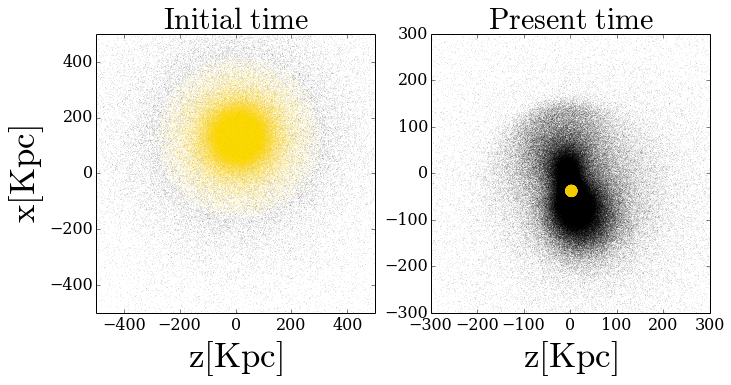

In [53]:
figure(figsize=(11,5))
subplot(1, 2, 1)
title('$\mathrm{Initial\ time}$', fontsize=30)
scatter(LMC_pos_out[:,0], LMC_pos_out[:,2], s=0.1, edgecolor='none', c='k')
scatter(LMC_inn_pos[:,0], LMC_inn_pos[:,2], s=0.1, edgecolor='none', c='gold')
xlim(-500, 500)
ylim(-500, 500)
xlabel('$\mathrm{z[Kpc]}$', fontsize=35)
ylabel('$\mathrm{x[Kpc]}$', fontsize=35)

subplot(1, 2, 2)
title('$\mathrm{Present\ time}$', fontsize=30)
scatter(LMC_pos_outf[:,0], LMC_pos_outf[:,2], s=0.1, edgecolor='none', c='k')
scatter(LMC_inn_posf[:,0], LMC_inn_posf[:,2], s=0.1, edgecolor='none', c='gold')
xlim(-300, 300)
ylim(-300, 300)
xlabel('$\mathrm{z[Kpc]}$', fontsize=35)

savefig('LMC_masks.png', bbox_inches='tight', dpi=300)




In [61]:
#The mass of the enclosed MW particles inside the LMC radius at the present time.

print sum(LMC_mass_inn)
print sum(LMC_mass_innf) + sum(LMC_mass_outf)
print sum(LMC_mass_out) + sum(LMC_mass_inn)


x_mw_lmc = (All_pos_outf[:,0]-lmc_orbit[119,0])
y_mw_lmc = (All_pos_outf[:,1]-lmc_orbit[119,1])
z_mw_lmc = (All_pos_outf[:,2]-lmc_orbit[119,2])

index_mw_inn = np.where(np.sqrt(x_mw_lmc**2.+y_mw_lmc**2.+z_mw_lmc**2.)<20.)[0]
print len(index_mw_inn)
print sum(All_mass_outf[index_mw_inn])
print sum(All_mass_outf[index_mw_inn])/sum(LMC_mass_inn)

14.7977
16.9447
16.9447
42523
6.67644
0.451181


In [40]:
2.5E11/500000.
print LMC_mass_inn

[  3.38893442e-05   3.38893442e-05   3.38893442e-05 ...,   3.38893442e-05
   3.38893442e-05   3.38893442e-05]


In [ ]:
## Checking how many MW particles are inside the LMC sphere.

